# 線形システムのフィードバック制御に関する検討

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 行列パラメータの設定

以下の行列パラメータは、文献「深層展開による出力フィードバック安定化の検討」小林他(2019)に基づく。

In [2]:
A = [-0.2 0.4 -1.0 -0.4;
    -0.7 -0.8 -0.6 -0.3;
    -0.2 0.1 -0.2 0.4;
    -0.6 0.8 -0.9 0.3]

4×4 Matrix{Float64}:
 -0.2   0.4  -1.0  -0.4
 -0.7  -0.8  -0.6  -0.3
 -0.2   0.1  -0.2   0.4
 -0.6   0.8  -0.9   0.3

$A$の固有値をみてみると実部に0.5799という正の値が含まれているため、開ループ系は不安定である。

In [3]:
eigvals(A)

4-element Vector{ComplexF64}:
  -0.5352524569241293 - 0.7958890318296892im
  -0.5352524569241293 + 0.7958890318296892im
 -0.40939507105097606 + 0.0im
   0.5798999848992342 + 0.0im

In [4]:
B = [-0.2 0.1;
    -0.7 -0.6;
    0.6 0.9;
    -0.4 0.4]

4×2 Matrix{Float64}:
 -0.2   0.1
 -0.7  -0.6
  0.6   0.9
 -0.4   0.4

In [5]:
C = [0.8 0.8 -0.8 -0.9;
    -0.7 0.8 -0.8 -0.2]

2×4 Matrix{Float64}:
  0.8  0.8  -0.8  -0.9
 -0.7  0.8  -0.8  -0.2

### 安定化を達成するゲイン行列の例

$K$を次のように取ると確かに$A + B K C$の固有値の実部はすべて負になる

In [6]:
K = [-2.7 2.7;
    2.7 -2.7]

2×2 Matrix{Float64}:
 -2.7   2.7
  2.7  -2.7

In [7]:
eigvals(A + B * K * C)

4-element Vector{ComplexF64}:
   -0.696594160082317 + 0.0im
   -0.173483428783485 - 1.637585256603538im
   -0.173483428783485 + 1.637585256603538im
 -0.15343898235071432 + 0.0im

確かに$A + B K C$の固有値の実部はたしかに全て負になっている

### グローバル変数の設定

In [8]:
T = 20.0
N = 500
η = T/N

0.04

### 常微分方程式を解く

微分方程式
$$
\frac{d}{dt} x(t)   = (A + B K C) x(t)
$$
を解くことでシステム応答を計算する

### オイラー法

In [9]:
function Euler(K)
    x = ones(4)
    x_trj = zeros(4, N)
    for i in 1:N
        x = x + η*(A + B*K*C)*x
        x_trj[:,i] = x
    end
    return x_trj[1,:], x_trj[2,:], x_trj[3,:], x_trj[4,:]
end        

Euler (generic function with 1 method)

### 解のプロット

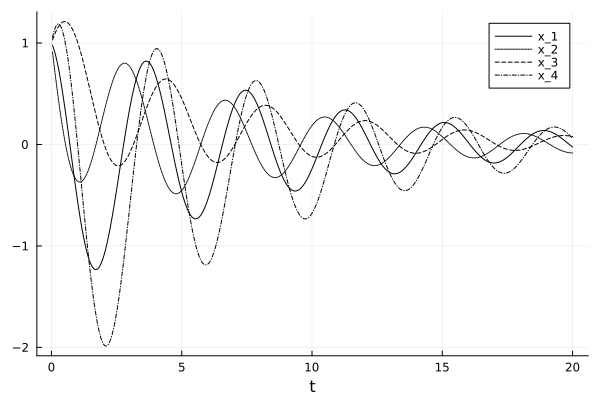

In [10]:
x1,x2,x3,x4 = Euler(K);
plot(η:η:T, x1, label="x_1", xlabel="t",color=:black)
plot!(η:η:T, x2, label="x_2",color=:black, ls=:dot)
plot!(η:η:T, x3, label="x_3",color=:black, ls=:dash)
plot!(η:η:T, x4, label="x_4",color=:black, ls=:dashdot)

In [11]:
savefig("DU-stabilize-1.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_5/DU-stabilize-1.pdf"

### DU-Euler法

$\|x(T)\|^2$の値を損失関数として利用している。

In [12]:
function DU_Euler(K)
    x = ones(4)
    for i in 1:N
        x = x + η*(A + B*K*C)*x
    end
    return norm(x)^2
end        

DU_Euler (generic function with 1 method)

### 学習プロセスと学習の結果 (学習の反復回数2回)

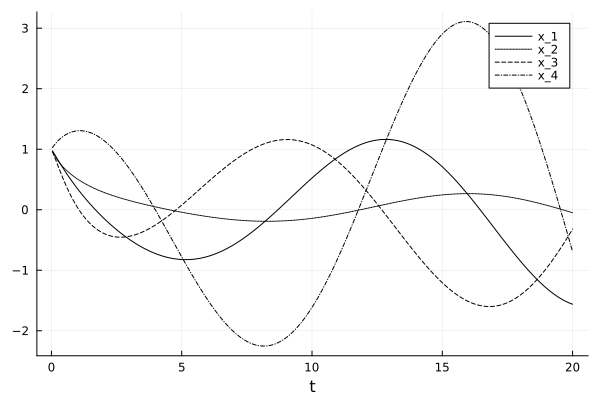

In [13]:
opt = Flux.ADAM(1e-0) 
train_itr = 2
K_train = ones(2,2)
ps = Flux.params(K_train)
for i in 1:train_itr
    gs = Flux.gradient(ps) do
        DU_Euler(K_train)
    end
    Flux.Optimise.update!(opt, ps, gs)
end
x1,x2,x3,x4 = Euler(K_train);
p1 = plot(η:η:T, x1, label="x_1", xlabel="t",color=:black)
plot!(η:η:T, x2, label="x_2",color=:black, ls=:dot)
plot!(η:η:T, x3, label="x_3",color=:black, ls=:dash)
plot!(η:η:T, x4, label="x_4",color=:black, ls=:dashdot)

In [14]:
savefig("DU-stabilize-2.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_5/DU-stabilize-2.pdf"

### 学習プロセスと学習の結果 (学習の反復回数20回)

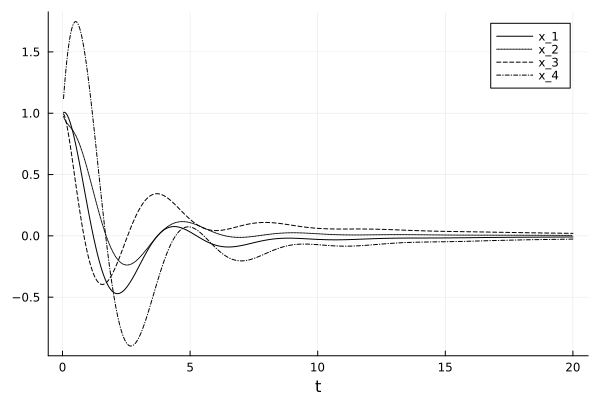

In [15]:
opt = Flux.ADAM(1e-0) 
train_itr = 20
K_train = ones(2,2)
ps = Flux.params(K_train)
for i in 1:train_itr
    gs = gradient(ps) do
        DU_Euler(K_train)
    end
    Flux.Optimise.update!(opt, ps, gs)
end
x1,x2,x3,x4 = Euler(K_train);
p2 = plot(η:η:T, x1, label="x_1", xlabel="t",color=:black)
plot!(η:η:T, x2, label="x_2",color=:black, ls=:dot)
plot!(η:η:T, x3, label="x_3",color=:black, ls=:dash)
plot!(η:η:T, x4, label="x_4",color=:black, ls=:dashdot)

In [16]:
savefig("DU-stabilize-3.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_5/DU-stabilize-3.pdf"